In [1]:
import torch
import numpy as np
import keras
import tensorflow as tf
from keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import pandas as pd
from matplotlib import rc
from pylab import rcParams
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'


register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)


# Check if GPU is available
if tf.test.is_gpu_available():
    print("GPU is available")
    print("GPU devices:", tf.config.list_physical_devices('GPU'))
else:
    print("GPU is not available")
    print("CPU devices:", tf.config.list_physical_devices('CPU'))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
GESTURES = [
    "A", "B", "C", "D", "E", "F", "G", "H", "I", "J",
    "K", "L","M", "N", "O", "P", "Q", "R", "S", "T",
    "U", "V","W", "X", "Y", "Z", "idle"
]

g = 9.80665
column_mapping = {
    'column_0': 'ax',
    'column_1': 'ay',
    'column_2': 'az',
    'column_3': 'gx',
    'column_4': 'gy',
    'column_5': 'gz',
}

NUM_OF_RECORDINGS = 400
dfs_train = []
for label in GESTURES:
    for i in range(NUM_OF_RECORDINGS):
        # if i >= 100 and i <= 199:
        #     continue
        df_train = pd.read_csv(f"csv/inofficial/{label}/{label}_{i}.csv")
        # print(f"csv/official/{label}/{label}_{i}.csv")
        df_train = df_train.rename(columns=column_mapping)
        df_train = df_train.iloc[15:85]
        df_train['label'] = label
        #normalize data by adding 4g to accelerometer data and divide by 8g
        df_train['ax'] = (df_train['ax'] / 8*g) 
        df_train['ay'] = (df_train['ay'] / 8*g) 
        df_train['az'] = (df_train['az'] / 8*g) 
        #normalize data by dividing by 2000 deg/s
        df_train['gx'] = (df_train['gx'] / 1000) 
        df_train['gy'] = (df_train['gy'] / 1000) 
        df_train['gz'] = (df_train['gz'] / 1000)
        dfs_train.append(df_train)
df_train = pd.concat(dfs_train)

print (df_train.shape)

(692062, 7)


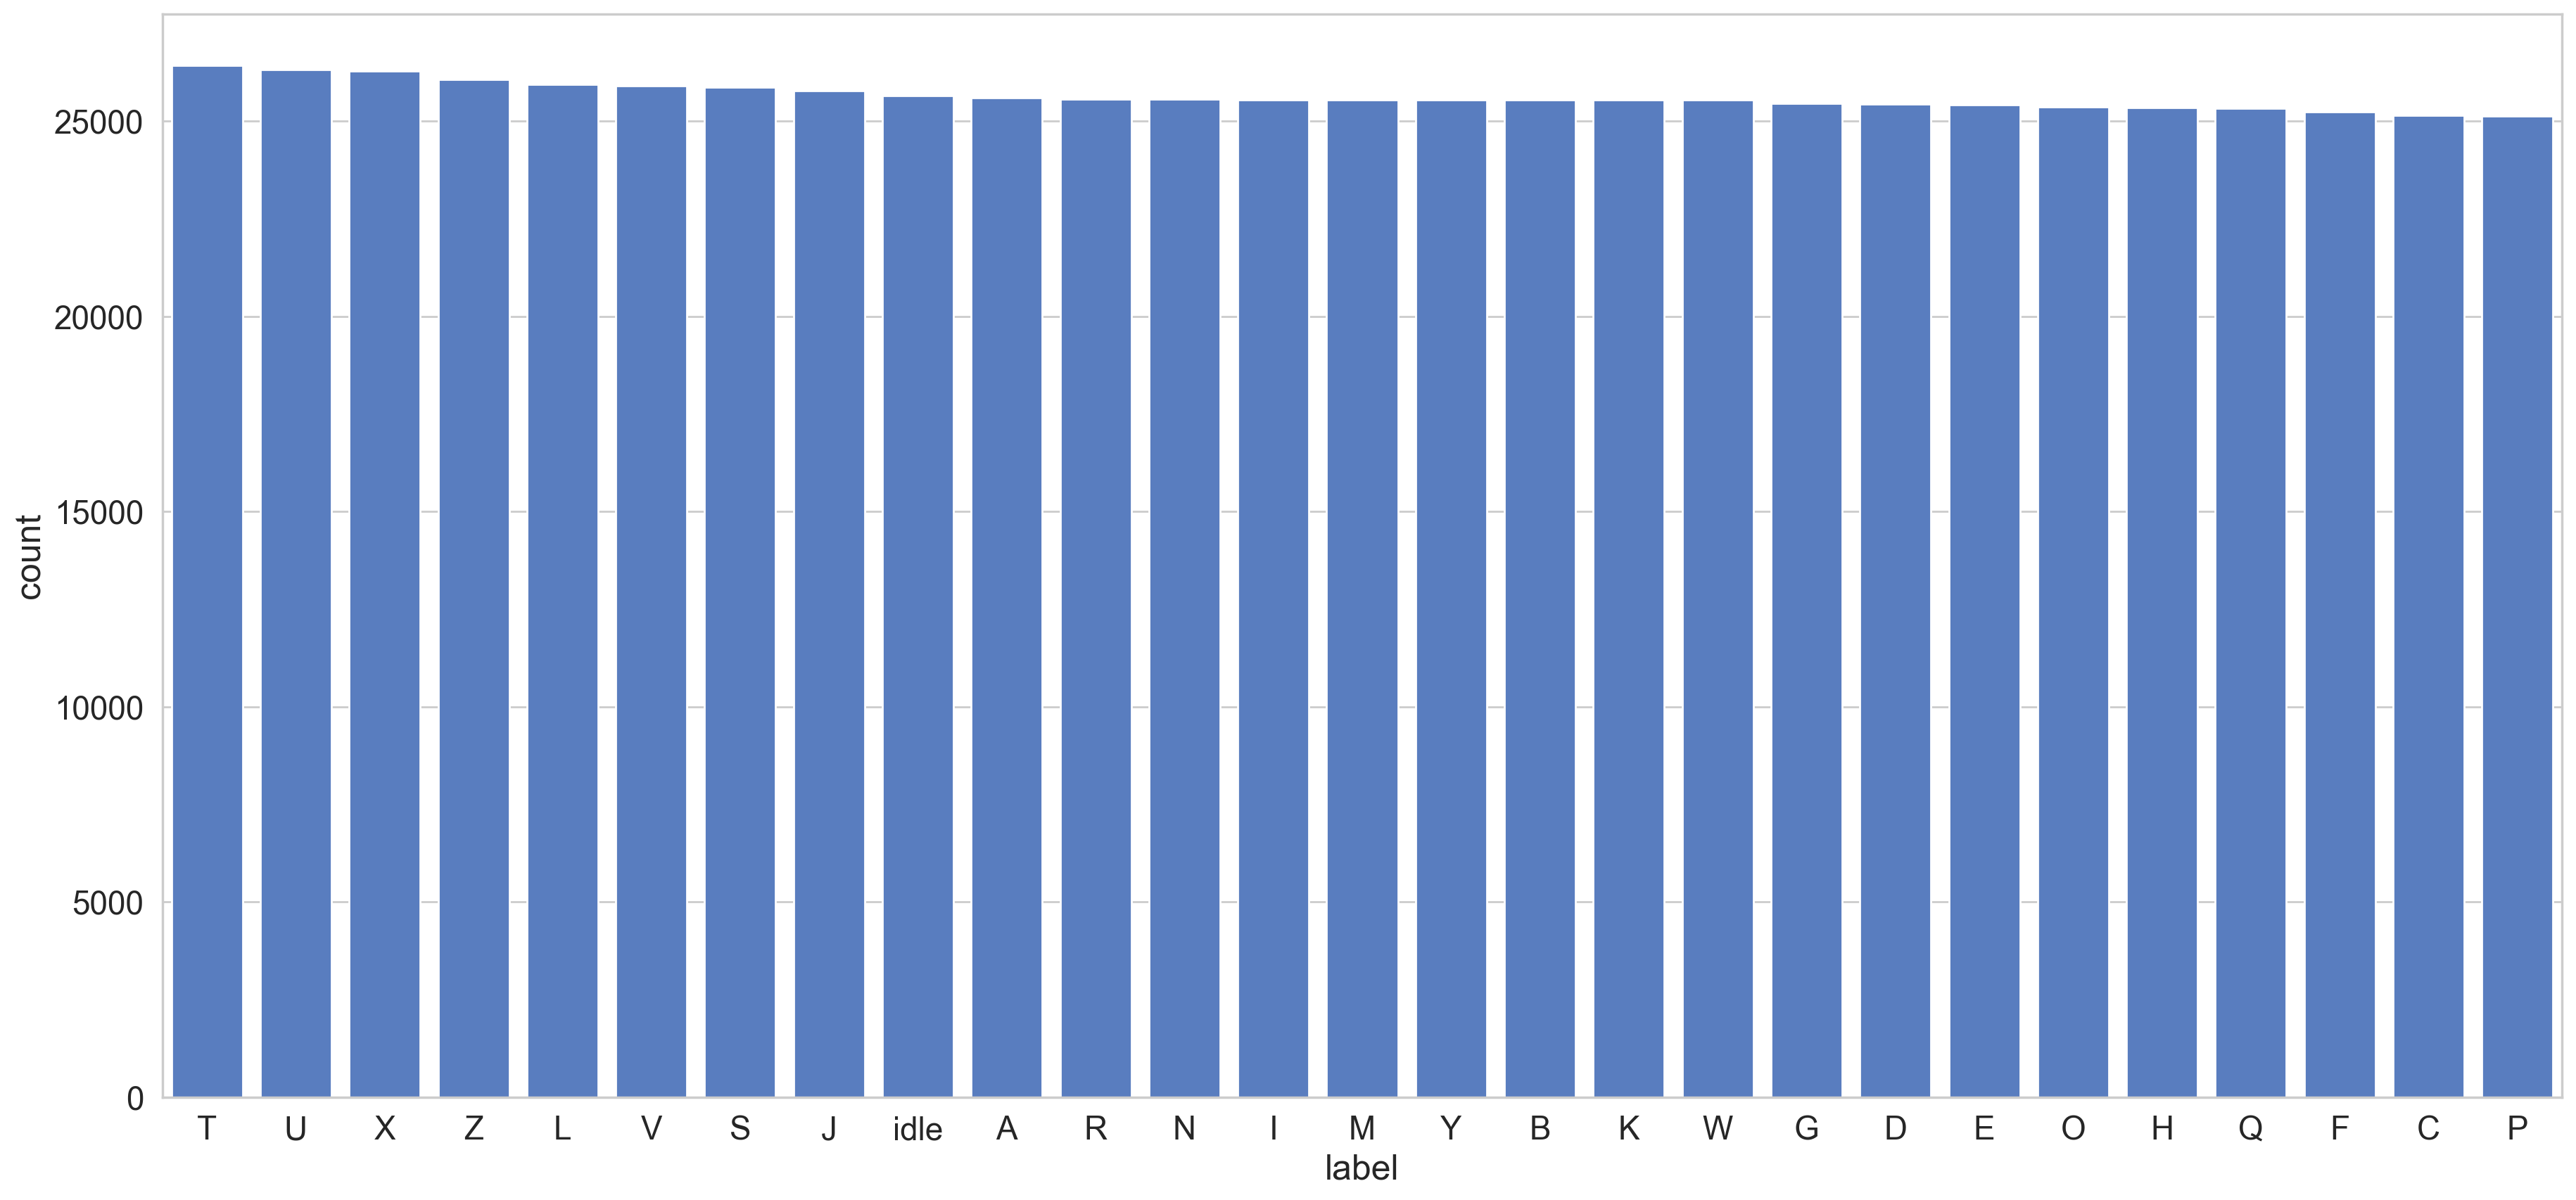

In [3]:
sns.countplot(x = 'label',
              data = df_train,
              order = df_train.label.value_counts().index);

In [4]:
def plot_label(label, df_train):
    data = df_train[df_train['label'] == label][['ax', 'ay', 'az','gx','gy','gz']][:70]
    axis = data.plot(subplots=True, figsize=(16, 12), title=label)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

In [5]:
# for label in GESTURES:
#     plot_label(label, df_train)

In [6]:
# from sklearn.preprocessing import RobustScaler

# scaler = RobustScaler()

# scaling_columns = ['ax', 'ay', 'az','gx','gy','gz']

# df_train[scaling_columns] = scaler.fit_transform(df_train[scaling_columns])


In [7]:
from sklearn.model_selection import train_test_split
def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(np.unique(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 70
STEP = 20

X_train, y_train = create_dataset(
    df_train[['ax', 'ay', 'az', 'gx', 'gy', 'gz']], 
    df_train.label, 
    TIME_STEPS, 
    STEP
)

X_train, X_validate, y_train, y_valiadate = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_SEED)

In [8]:
print(X_train.shape, y_train.shape)

(27680, 70, 6) (27680, 1)


In [9]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_valiadate = enc.transform(y_valiadate)

In [10]:
print(X_validate.shape, y_valiadate.shape)

(6920, 70, 6) (6920, 27)


In [11]:

model = keras.Sequential()
model.add(
      keras.layers.LSTM(
          units=128, 
        #   return_sequences=True,
          input_shape=[X_train.shape[1], X_train.shape[2]]
      )
)
# model.add(keras.layers.Dropout(rate=0.5))
# model.add(
#       keras.layers.LSTM(
#           units=64,  # Second LSTM layer with different units
#       )
# )
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
keras.utils.plot_model(model, show_shapes=True, to_file='model.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [12]:
history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_validate, y_valiadate),
)
model.summary()
model.save('lstm_raw')

Epoch 1/15
865/865 [==============================] - 23s 16ms/step - loss: 1.7623 - acc: 0.4756 - val_loss: 0.7163 - val_acc: 0.7837
Epoch 2/15
865/865 [==============================] - 11s 13ms/step - loss: 0.7135 - acc: 0.7821 - val_loss: 0.4675 - val_acc: 0.8532
Epoch 3/15
865/865 [==============================] - 12s 13ms/step - loss: 0.4802 - acc: 0.8517 - val_loss: 0.3530 - val_acc: 0.8864
Epoch 4/15
865/865 [==============================] - 11s 12ms/step - loss: 0.3771 - acc: 0.8859 - val_loss: 0.2515 - val_acc: 0.9221
Epoch 5/15
865/865 [==============================] - 10s 12ms/step - loss: 0.3101 - acc: 0.9073 - val_loss: 0.2168 - val_acc: 0.9342
Epoch 6/15
865/865 [==============================] - 10s 12ms/step - loss: 0.2456 - acc: 0.9250 - val_loss: 0.1799 - val_acc: 0.9475
Epoch 7/15
865/865 [==============================] - 10s 12ms/step - loss: 0.2313 - acc: 0.9307 - val_loss: 0.1675 - val_acc: 0.9523
Epoch 8/15
865/865 [==============================] - 11s 12ms

INFO:tensorflow:Assets written to: lstm_raw\assets


INFO:tensorflow:Assets written to: lstm_raw\assets


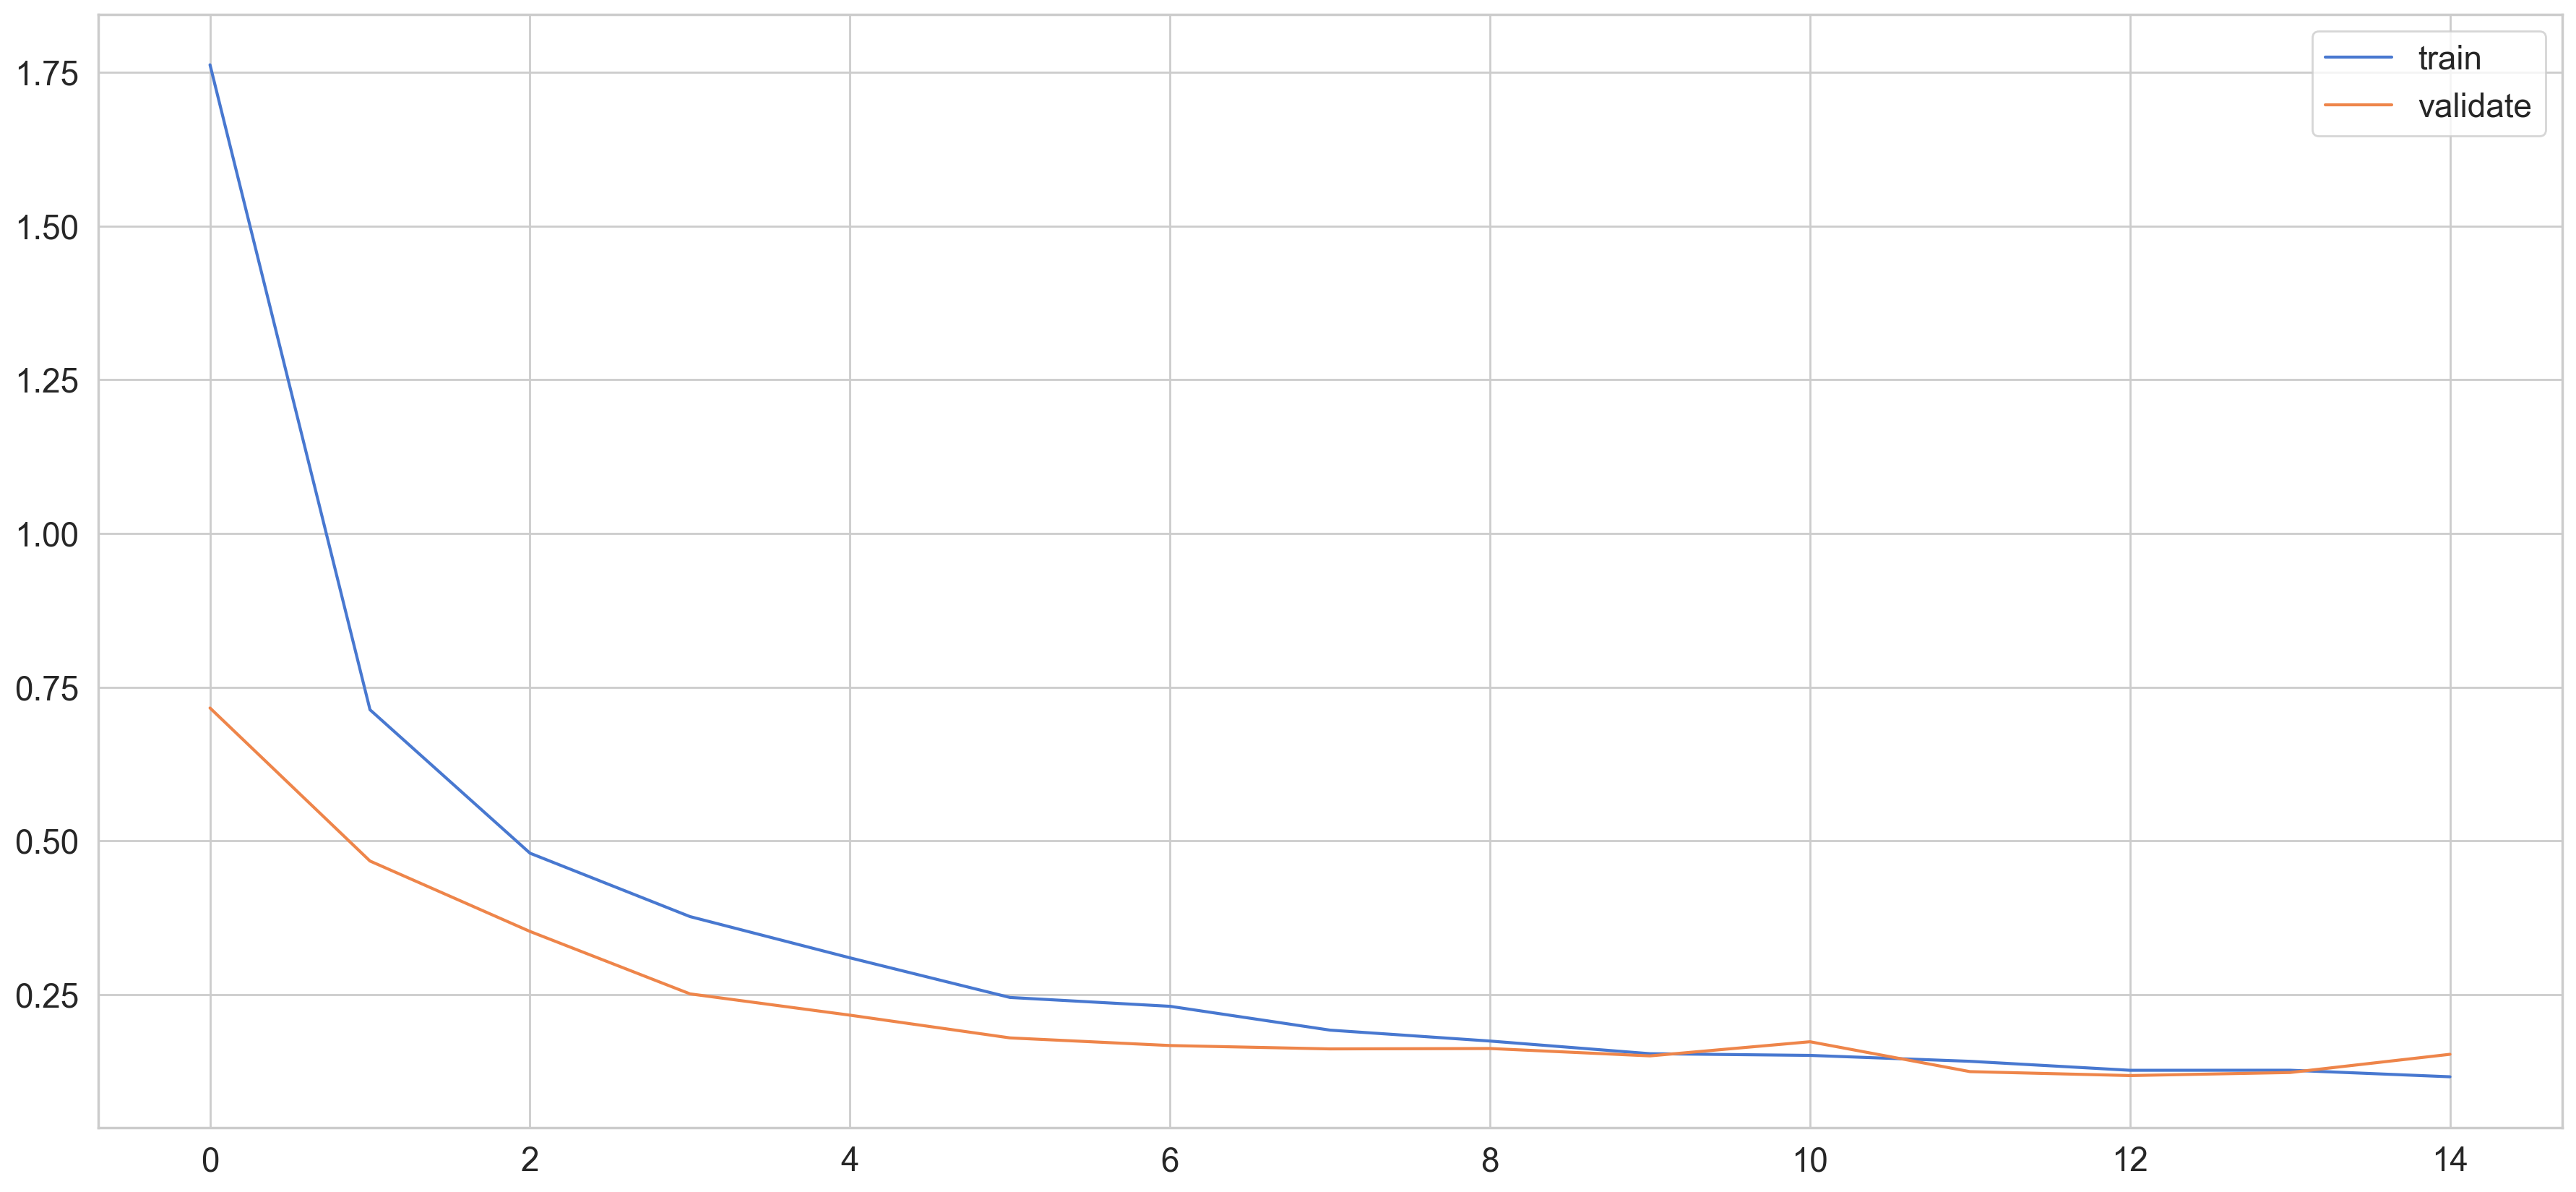

In [13]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validate')
plt.legend();

In [14]:
# model.evaluate(X_test, y_test)